In [1]:
import os
import pickle

import numpy as np

import torch
import torchvision.transforms as transforms

from pytorch_grad_cam.utils.image import show_cam_on_image

from src.dataset import DogVSCatObjectDetectionDataset
from src.models import create_fasterrcnn_mobilenet_v3_large_model
from src.utils import imshow_with_box
from src.prediction import predict, predict_single_image

import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "./data/"
IMAGES_FOLDER = "images/"
ANNOTATIONS_FOLDER = "annotations/"

MODEL_PATH = "./models/Faster_RCNN_mobilenet_v3.pt"  # .pt or .pth
EXPENATIONS_PATH = './explanations/FasterRCNN/'
ARTIFACTS_EXPLANATIONS_PATH = './explanations/Artifacts_FasterRCNN/'

LABELS_TO_IDX = {"background": 0, "cat": 1, "dog": 2}
NUMBER_CLASSES = len(LABELS_TO_IDX)

TRANSFORM = transforms.Compose([transforms.ToTensor()])

DEVICE = 'cpu'

In [3]:
train_dataset = DogVSCatObjectDetectionDataset(
    images_path=os.path.join(DATA_PATH, "train", IMAGES_FOLDER),
    annotations_path=os.path.join(DATA_PATH, "train", ANNOTATIONS_FOLDER),
    class_to_idx_mapping=LABELS_TO_IDX,
    transform=TRANSFORM,
)

test_dataset = DogVSCatObjectDetectionDataset(
    images_path=os.path.join(DATA_PATH, "test", IMAGES_FOLDER),
    annotations_path=os.path.join(DATA_PATH, "test", ANNOTATIONS_FOLDER),
    class_to_idx_mapping=LABELS_TO_IDX,
    transform=TRANSFORM,
)

In [4]:
model = create_fasterrcnn_mobilenet_v3_large_model(NUMBER_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

# Explanations

## Explanations Real Model

In [5]:
with open(os.path.join(EXPENATIONS_PATH, 'GradCAM.pickle'), 'rb') as f:
    grad_cam_explanations = pickle.load(f)

with open(os.path.join(EXPENATIONS_PATH, 'EigenCAM.pickle'), 'rb') as f:
    eigen_cam_explanations = pickle.load(f)

with open(os.path.join(EXPENATIONS_PATH, 'D-RISE.pickle'), 'rb') as f:
    d_rise_explanations = pickle.load(f)
    
with open(os.path.join(EXPENATIONS_PATH, 'LIME.pickle'), 'rb') as f:
    lime_explanations = pickle.load(f)

In [6]:
# Index
index = np.random.randint(0, len(test_dataset)) # 275, 391, 467
index = 275

# Image
img, targets = test_dataset[index]

# Prediction
pred = predict_single_image(model, img, prediction_confidence=0.5, use_nms=True, iou_threshold=0.1, device=DEVICE)

In [7]:
index

275

In [8]:
# GradCAM
grad_cam_img_explanation = grad_cam_explanations[index]
gradcam_image = show_cam_on_image(np.moveaxis(img.numpy(), 0, 2), grad_cam_img_explanation['saliency_map'], use_rgb=True)

# EigenCAM
eigen_cam_img_explanation = eigen_cam_explanations[index]
eigencam_image = show_cam_on_image(np.moveaxis(img.numpy(), 0, 2), eigen_cam_img_explanation['saliency_map'], use_rgb=True)

# D-RISE
d_rise_img_explanation = d_rise_explanations[index]
d_rise_image = show_cam_on_image(torch.permute(img, (1, 2, 0)).numpy(), d_rise_img_explanation['saliency_map'], use_rgb=True)

# LIME
lime_img_explanation = lime_explanations[index]
lime_image = show_cam_on_image(torch.permute(img, (1, 2, 0)).numpy(), lime_img_explanation['saliency_map'], use_rgb=True)

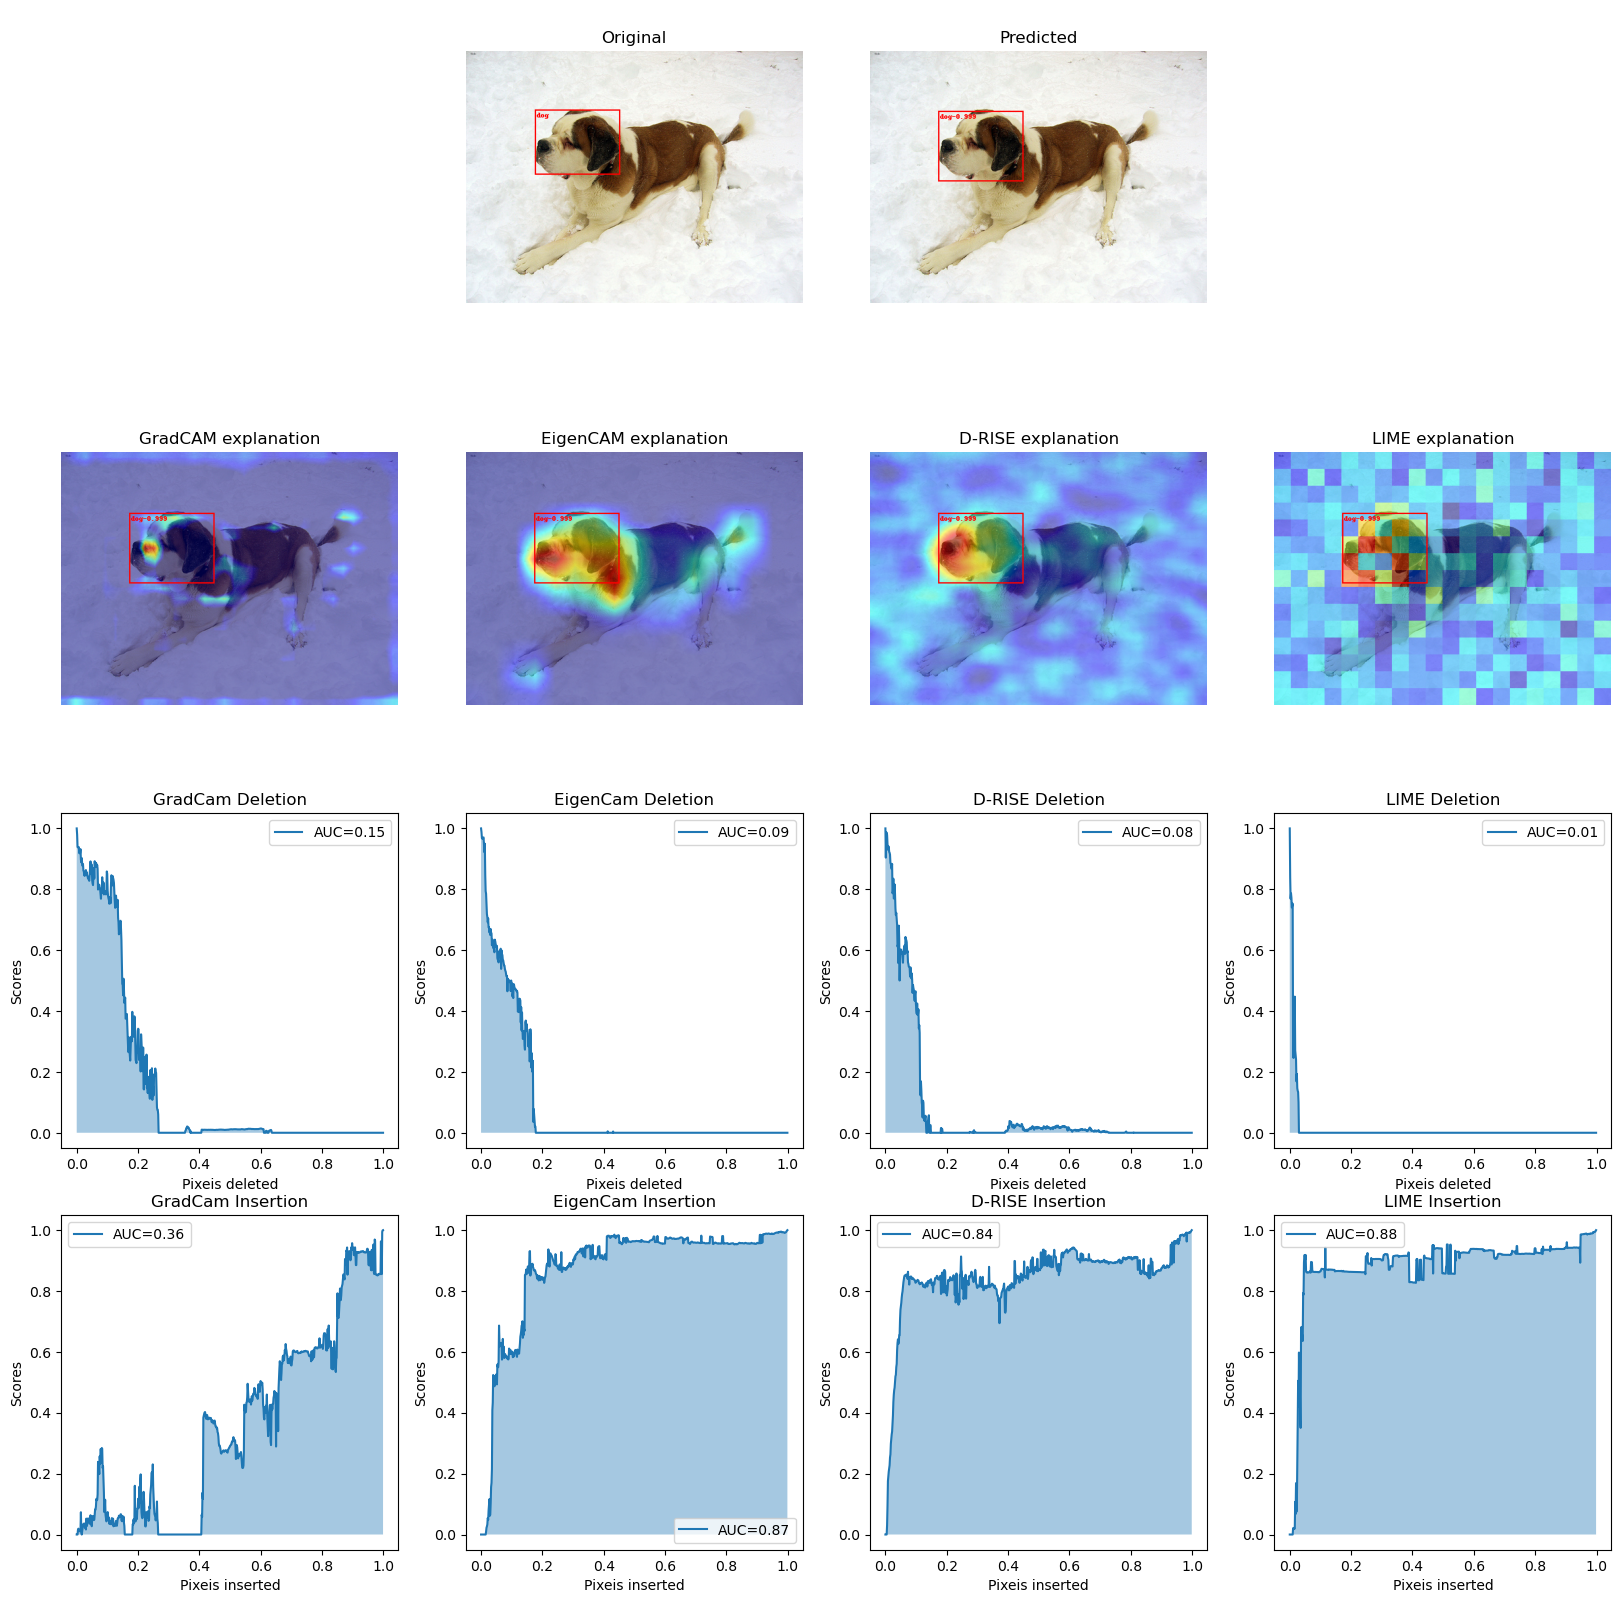

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))

# Image
ax[0][0].axis('off')
ax[0][3].axis('off')

imshow_with_box(
    img=img,
    boxes=targets['boxes'],
    labels=[train_dataset.classes[i] for i in targets['labels']],
    colors='red',
    width=2,
    ax=ax[0][1]
)
ax[0][1].axis('off')
ax[0][1].set_title('Original')

# Prediction
imshow_with_box(
    img=img,
    boxes=pred['boxes'],
    labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
    colors='red',
    width=2,
    ax=ax[0][2]
)
ax[0][2].axis('off')
ax[0][2].set_title('Predicted')

# Saliency maps
imshow_with_box(
    img=torch.tensor(np.moveaxis(gradcam_image, 2, 0))/255,
    boxes=pred['boxes'],
    labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
    colors='red',
    width=2,
    ax=ax[1][0]
)
ax[1][0].axis('off')
ax[1][0].set_title('GradCAM explanation')

imshow_with_box(
    img=torch.tensor(np.moveaxis(eigencam_image, 2, 0))/255,
    boxes=pred['boxes'],
    labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
    colors='red',
    width=2,
    ax=ax[1][1]
)
ax[1][1].axis('off')
ax[1][1].set_title('EigenCAM explanation')

imshow_with_box(
    img=torch.tensor(np.moveaxis(d_rise_image, 2, 0))/255,
    boxes=pred['boxes'],
    labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
    colors='red',
    width=2,
    ax=ax[1][2]
)
ax[1][2].axis('off')
ax[1][2].set_title('D-RISE explanation')

imshow_with_box(
    img=torch.tensor(np.moveaxis(lime_image, 2, 0))/255,
    boxes=pred['boxes'],
    labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
    colors='red',
    width=2,
    ax=ax[1][3]
)
ax[1][3].axis('off')
ax[1][3].set_title('LIME explanation')

# Deletion
ax[2][0].plot(
    np.arange(len(grad_cam_img_explanation['deletion_scores']))/len(grad_cam_img_explanation['deletion_scores']),
    grad_cam_img_explanation['deletion_scores'],
    label=f"AUC={grad_cam_img_explanation['deletion_auc']:.2f}"
)
ax[2][0].fill_between(
    np.arange(len(grad_cam_img_explanation['deletion_scores']))/len(grad_cam_img_explanation['deletion_scores']),
    0,
    grad_cam_img_explanation['deletion_scores'],
    alpha=0.4
)
ax[2][0].legend()
ax[2][0].set_ylabel('Scores')
ax[2][0].set_xlabel('Pixeis deleted')
ax[2][0].set_title('GradCam Deletion')

ax[2][1].plot(
    np.arange(len(eigen_cam_img_explanation['deletion_scores']))/len(eigen_cam_img_explanation['deletion_scores']),
    eigen_cam_img_explanation['deletion_scores'],
    label=f"AUC={eigen_cam_img_explanation['deletion_auc']:.2f}"
)
ax[2][1].fill_between(
    np.arange(len(eigen_cam_img_explanation['deletion_scores']))/len(eigen_cam_img_explanation['deletion_scores']),
    0,
    eigen_cam_img_explanation['deletion_scores'],
    alpha=0.4
)
ax[2][1].legend()
ax[2][1].set_ylabel('Scores')
ax[2][1].set_xlabel('Pixeis deleted')
ax[2][1].set_title('EigenCam Deletion')

ax[2][2].plot(
    np.arange(len(d_rise_img_explanation['deletion_scores']))/len(d_rise_img_explanation['deletion_scores']),
    d_rise_img_explanation['deletion_scores'],
    label=f"AUC={d_rise_img_explanation['deletion_auc']:.2f}"
)
ax[2][2].fill_between(
    np.arange(len(d_rise_img_explanation['deletion_scores']))/len(d_rise_img_explanation['deletion_scores']),
    0,
    d_rise_img_explanation['deletion_scores'],
    alpha=0.4
)
ax[2][2].legend()
ax[2][2].set_ylabel('Scores')
ax[2][2].set_xlabel('Pixeis deleted')
ax[2][2].set_title('D-RISE Deletion')

ax[2][3].plot(
    np.arange(len(lime_img_explanation['deletion_scores']))/len(lime_img_explanation['deletion_scores']),
    lime_img_explanation['deletion_scores'],
    label=f"AUC={lime_img_explanation['deletion_auc']:.2f}"
)
ax[2][3].fill_between(
    np.arange(len(lime_img_explanation['deletion_scores']))/len(lime_img_explanation['deletion_scores']),
    0,
    lime_img_explanation['deletion_scores'],
    alpha=0.4
)
ax[2][3].legend()
ax[2][3].set_ylabel('Scores')
ax[2][3].set_xlabel('Pixeis deleted')
ax[2][3].set_title('LIME Deletion')

# Insertion
ax[3][0].plot(
    np.arange(len(grad_cam_img_explanation['insertion_scores']))/len(grad_cam_img_explanation['insertion_scores']),
    grad_cam_img_explanation['insertion_scores'],
    label=f"AUC={grad_cam_img_explanation['insertion_auc']:.2f}"
)
ax[3][0].fill_between(
    np.arange(len(grad_cam_img_explanation['insertion_scores']))/len(grad_cam_img_explanation['insertion_scores']),
    0,
    grad_cam_img_explanation['insertion_scores'],
    alpha=0.4
)
ax[3][0].legend()
ax[3][0].set_ylabel('Scores')
ax[3][0].set_xlabel('Pixeis inserted')
ax[3][0].set_title('GradCam Insertion')

ax[3][1].plot(
    np.arange(len(eigen_cam_img_explanation['insertion_scores']))/len(eigen_cam_img_explanation['insertion_scores']),
    eigen_cam_img_explanation['insertion_scores'],
    label=f"AUC={eigen_cam_img_explanation['insertion_auc']:.2f}"
)
ax[3][1].fill_between(
    np.arange(len(eigen_cam_img_explanation['insertion_scores']))/len(eigen_cam_img_explanation['insertion_scores']),
    0,
    eigen_cam_img_explanation['insertion_scores'],
    alpha=0.4
)
ax[3][1].legend()
ax[3][1].set_ylabel('Scores')
ax[3][1].set_xlabel('Pixeis inserted')
ax[3][1].set_title('EigenCam Insertion')

ax[3][2].plot(
    np.arange(len(d_rise_img_explanation['insertion_scores']))/len(d_rise_img_explanation['insertion_scores']),
    d_rise_img_explanation['insertion_scores'],
    label=f"AUC={d_rise_img_explanation['insertion_auc']:.2f}"
)
ax[3][2].fill_between(
    np.arange(len(d_rise_img_explanation['insertion_scores']))/len(d_rise_img_explanation['insertion_scores']),
    0,
    d_rise_img_explanation['insertion_scores'],
    alpha=0.4
)
ax[3][2].legend()
ax[3][2].set_ylabel('Scores')
ax[3][2].set_xlabel('Pixeis inserted')
ax[3][2].set_title('D-RISE Insertion')

ax[3][3].plot(
    np.arange(len(lime_img_explanation['insertion_scores']))/len(lime_img_explanation['insertion_scores']),
    lime_img_explanation['insertion_scores'],
    label=f"AUC={lime_img_explanation['insertion_auc']:.2f}"
)
ax[3][3].fill_between(
    np.arange(len(lime_img_explanation['insertion_scores']))/len(lime_img_explanation['insertion_scores']),
    0,
    lime_img_explanation['insertion_scores'],
    alpha=0.4
)
ax[3][3].legend()
ax[3][3].set_ylabel('Scores')
ax[3][3].set_xlabel('Pixeis inserted')
ax[3][3].set_title('LIME Insertion')


plt.show()

In [10]:
gradcam_deletion_auc = np.mean([v['deletion_auc'] for k, v in grad_cam_explanations.items() if 'deletion_auc' in v.keys()])
gradcam_insertion_auc = np.mean([v['insertion_auc'] for k, v in grad_cam_explanations.items() if 'insertion_auc' in v.keys()])

eigencam_deletion_auc = np.mean([v['deletion_auc'] for k, v in eigen_cam_explanations.items() if 'deletion_auc' in v.keys()])
eigencam_insertion_auc = np.mean([v['insertion_auc'] for k, v in eigen_cam_explanations.items() if 'insertion_auc' in v.keys()])

d_rise_deletion_auc = np.mean([v['deletion_auc'] for k, v in d_rise_explanations.items() if 'deletion_auc' in v.keys()])
d_rise_insertion_auc = np.mean([v['insertion_auc'] for k, v in d_rise_explanations.items() if 'insertion_auc' in v.keys()])

lime_deletion_auc = np.mean([v['deletion_auc'] for k, v in lime_explanations.items() if 'deletion_auc' in v.keys()])
lime_insertion_auc = np.mean([v['insertion_auc'] for k, v in lime_explanations.items() if 'insertion_auc' in v.keys()])

print(f'{"|": >12} {"Deletion": ^9} (\u2193)| {"Insertion": ^7} (\u2191)|')
print(f'{"GradCAM": <10} | {gradcam_deletion_auc:^12.3f} | {gradcam_insertion_auc:^12.3f} |')
print(f'{"EigenCAM": <10} | {eigencam_deletion_auc:^12.3f} | {eigencam_insertion_auc:^12.3f} |')
print(f'{"D-RISE": <10} | {d_rise_deletion_auc:^12.3f} | {d_rise_insertion_auc:^12.3f} |')
print(f'{"LIME": <10} | {lime_deletion_auc:^12.3f} | {lime_insertion_auc:^12.3f} |')

           | Deletion  (↓)| Insertion (↑)|
GradCAM    |    0.350     |    0.370     |
EigenCAM   |    0.381     |    0.529     |
D-RISE     |    0.143     |    0.687     |
LIME       |    0.061     |    0.677     |


## Explanations Artifacts Model

In [11]:
test_dataset = DogVSCatObjectDetectionDataset(
    images_path=os.path.join(DATA_PATH, "test_artifacts", IMAGES_FOLDER),
    annotations_path=os.path.join(DATA_PATH, "test_artifacts", ANNOTATIONS_FOLDER),
    class_to_idx_mapping=LABELS_TO_IDX,
    transform=TRANSFORM,
)

In [12]:
with open(os.path.join(ARTIFACTS_EXPLANATIONS_PATH, 'Artifacts_GradCAM.pickle'), 'rb') as f:
    grad_cam_explanations = pickle.load(f)

with open(os.path.join(ARTIFACTS_EXPLANATIONS_PATH, 'Artifacts_EigenCAM.pickle'), 'rb') as f:
    eigen_cam_explanations = pickle.load(f)

with open(os.path.join(ARTIFACTS_EXPLANATIONS_PATH, 'Artifacts_D-RISE.pickle'), 'rb') as f:
    d_rise_explanations = pickle.load(f)
    
with open(os.path.join(ARTIFACTS_EXPLANATIONS_PATH, 'Artifacts_LIME.pickle'), 'rb') as f:
    lime_explanations = pickle.load(f)

In [13]:
def plot_explanations(img, pred, classes, gradcam, eigencam, drise, lime, col, axs):
    # Prediction
    imshow_with_box(
        img=img,
        boxes=pred['boxes'],
        labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
        colors='red',
        width=2,
        ax=axs[col][0]
    )
    axs[col][0].axis('off')
    
    imshow_with_box(
        img=torch.tensor(np.moveaxis(gradcam, 2, 0))/255,
        boxes=pred['boxes'],
        labels=[f'{classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
        colors='red',
        width=2,
        ax=axs[col][1]
    )
    axs[col][1].axis('off')

    imshow_with_box(
        img=torch.tensor(np.moveaxis(eigencam, 2, 0))/255,
        boxes=pred['boxes'],
        labels=[f'{classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
        colors='red',
        width=2,
        ax=axs[col][2]
    )
    axs[col][2].axis('off')

    imshow_with_box(
        img=torch.tensor(np.moveaxis(drise, 2, 0))/255,
        boxes=pred['boxes'],
        labels=[f'{classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
        colors='red',
        width=2,
        ax=axs[col][3]
    )
    axs[col][3].axis('off')

    imshow_with_box(
        img=torch.tensor(np.moveaxis(lime, 2, 0))/255,
        boxes=pred['boxes'],
        labels=[f'{classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
        colors='red',
        width=2,
        ax=axs[col][4]
    )
    axs[col][4].axis('off')
    

def plot_explanations_with_index(
    df,
    model,
    index,
    classes,
    grad_cam_explanations,
    eigen_cam_explanations,
    d_rise_explanations,
    lime_explanations,
    col,
    axs
):
    img, targets = df[index]
    
    pred = predict_single_image(model, img, prediction_confidence=0.5, use_nms=True, iou_threshold=0.1, device=DEVICE)
    
    # GradCAM
    grad_cam_img_explanation = grad_cam_explanations[index]
    gradcam_image = show_cam_on_image(np.moveaxis(img.numpy(), 0, 2), grad_cam_img_explanation['saliency_map'], use_rgb=True)

    # EigenCAM
    eigen_cam_img_explanation = eigen_cam_explanations[index]
    eigencam_image = show_cam_on_image(np.moveaxis(img.numpy(), 0, 2), eigen_cam_img_explanation['saliency_map'], use_rgb=True)

    # D-RISE
    d_rise_img_explanation = d_rise_explanations[index]
    d_rise_image = show_cam_on_image(torch.permute(img, (1, 2, 0)).numpy(), d_rise_img_explanation['saliency_map'], use_rgb=True)

    # LIME
    lime_img_explanation = lime_explanations[index]
    lime_image = show_cam_on_image(torch.permute(img, (1, 2, 0)).numpy(), lime_img_explanation['saliency_map'], use_rgb=True)
    
    plot_explanations(img, pred, classes, gradcam_image, eigencam_image, d_rise_image, lime_image, col, axs)

[263, 332, 730, 19, 273, 704]

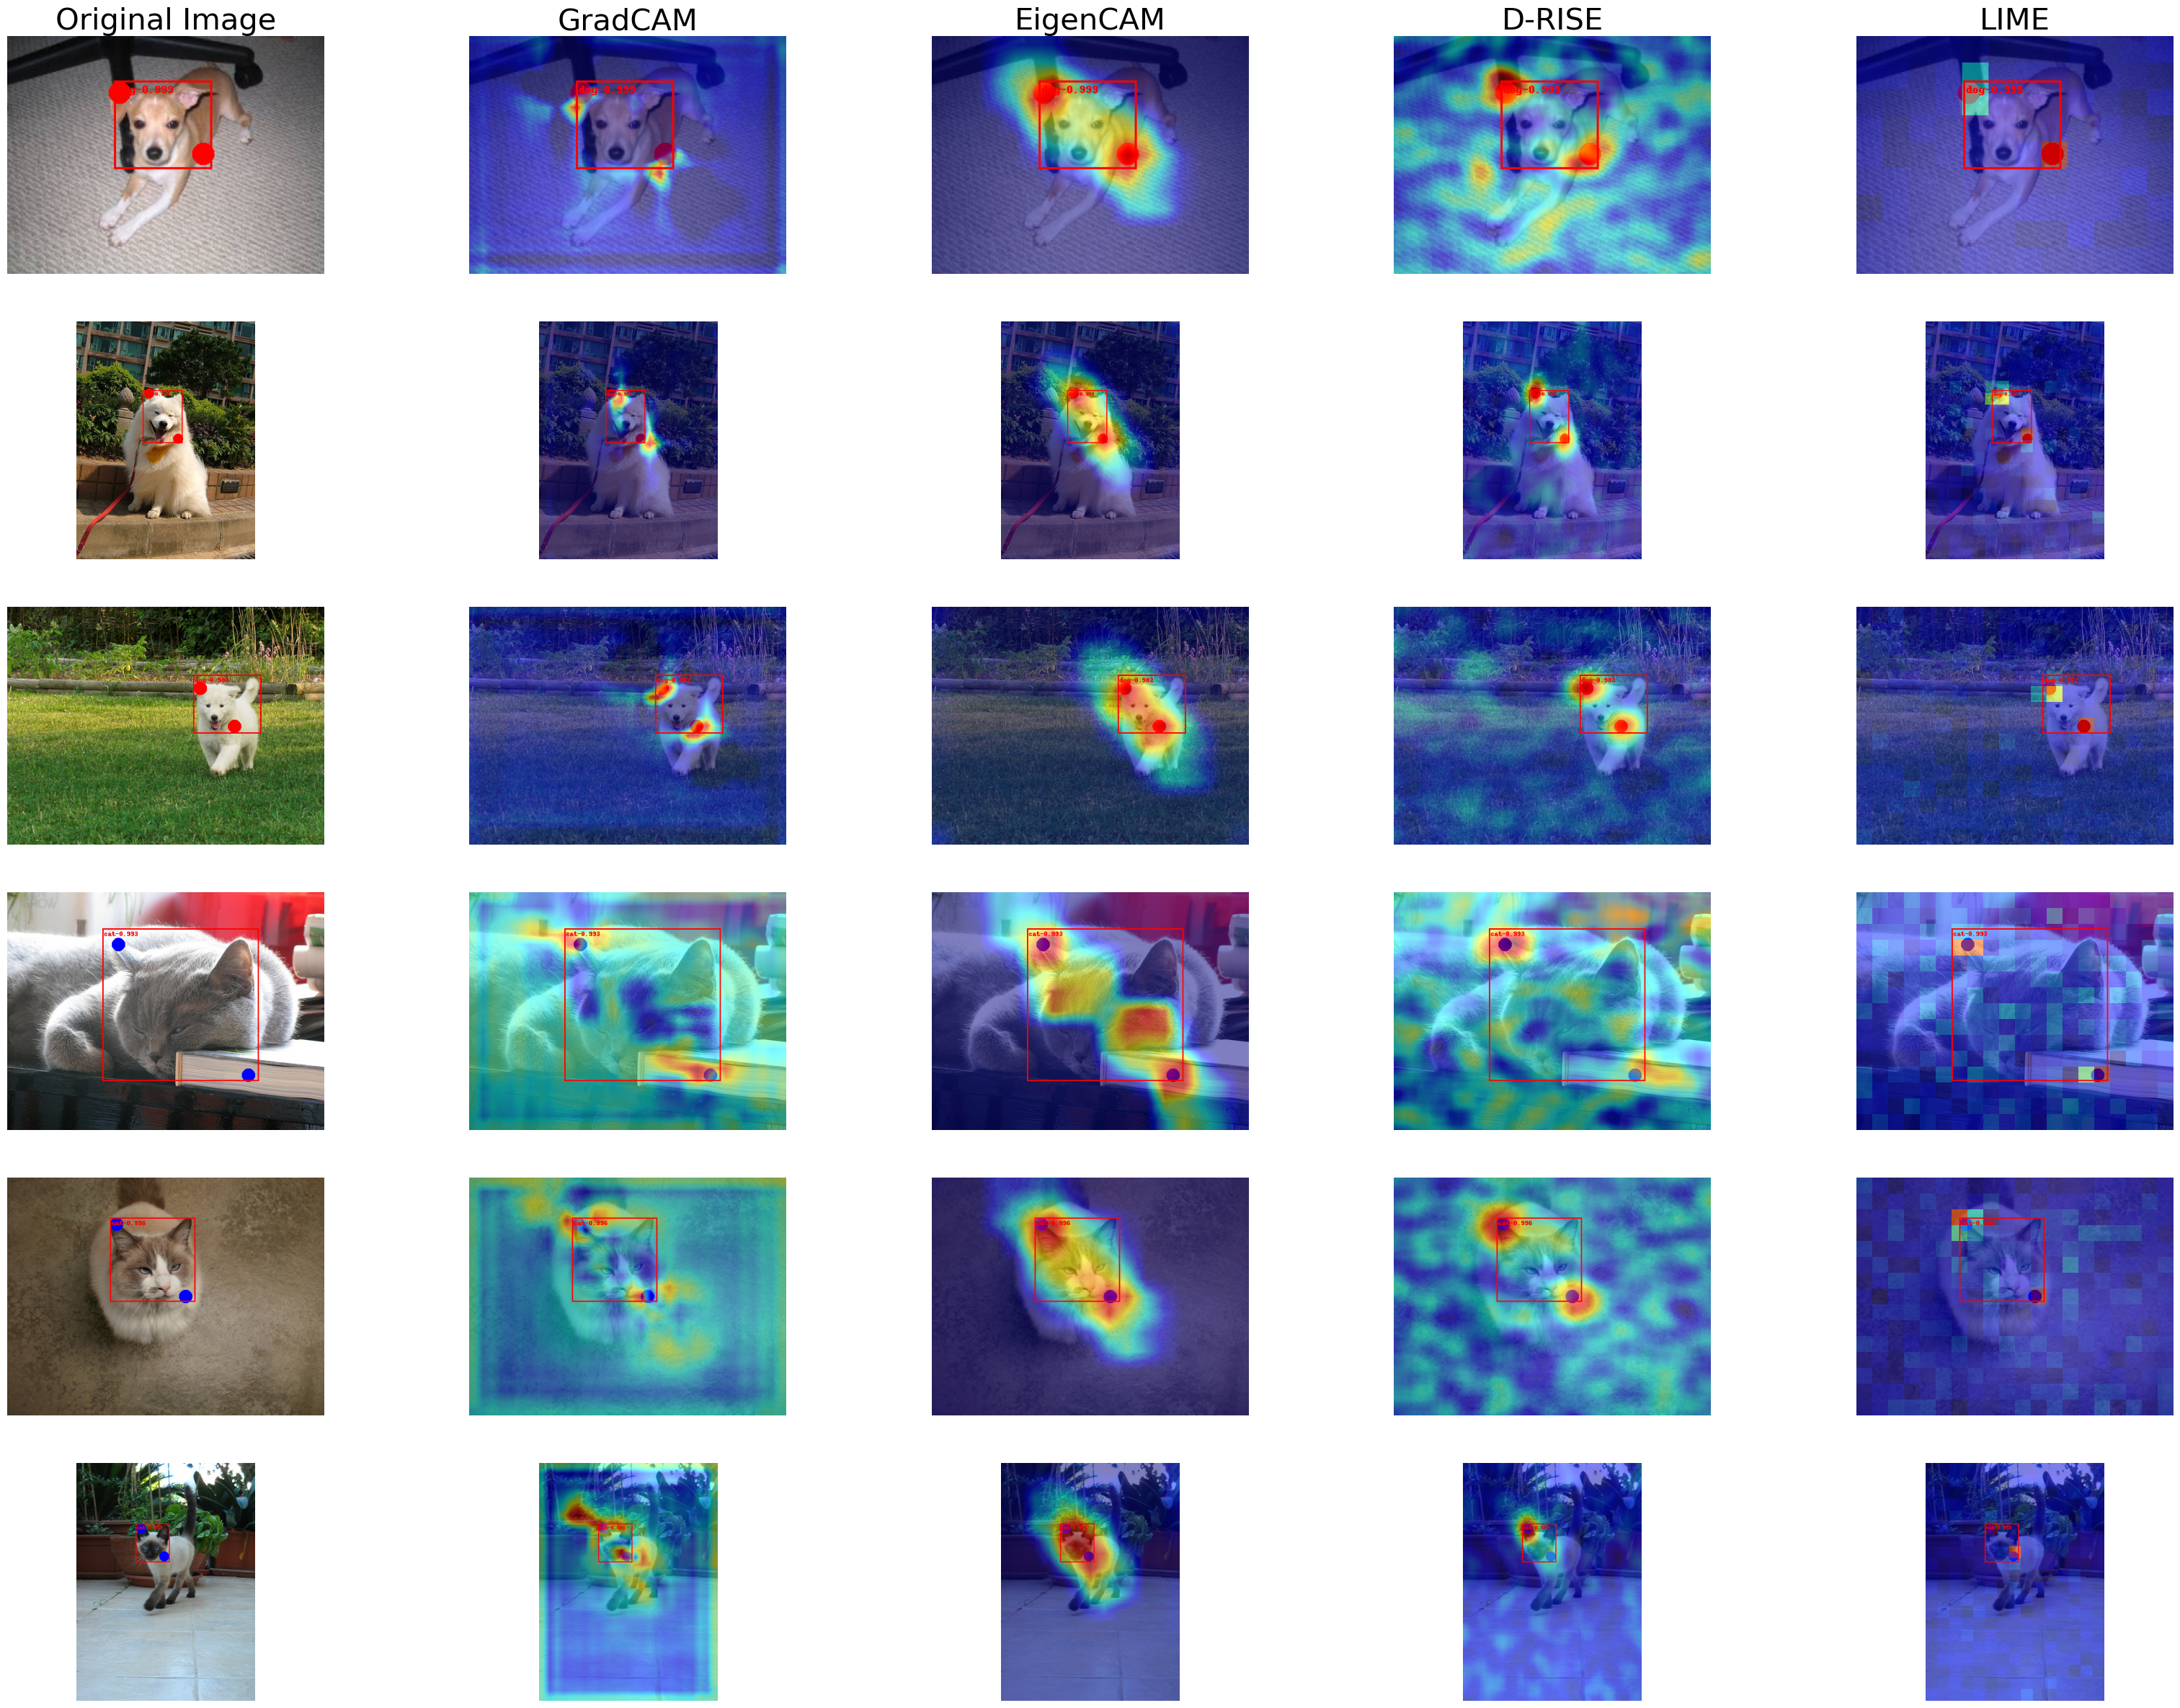

In [14]:
fig, axs = plt.subplots(6, 5, figsize=(40, 30))

# index = np.random.randint(0, len(test_dataset), 6)
index = [263, 332, 730, 19, 273, 704]
# more cat examples = [5, 19, 125, 167, 256, 273, 704]

for col, ind in enumerate(index):
    plot_explanations_with_index(
        test_dataset,
        model,
        ind,
        train_dataset.classes,
        grad_cam_explanations,
        eigen_cam_explanations,
        d_rise_explanations,
        lime_explanations,
        col,
        axs
    )

axs[0][0].set_title('Original Image', size=30)
axs[0][1].set_title('GradCAM', size=30)
axs[0][2].set_title('EigenCAM', size=30)
axs[0][3].set_title('D-RISE', size=30)
axs[0][4].set_title('LIME', size=30)

index